# Example 1 - continuum vs. site explicit and boundary conditions

**Running the code in this notebook takes approximately 81 minutes ( example 1: 21 minutes, example 2: 13 minutes, example 3: 23 minutes, example 4: 24 minutes). (iMac with 4 Ghz i7 processor).**

This is due to the Poisson-Boltzmann solver being run multiple times to minimise the difference between input and output mole fractions.

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.sites_data_importer import calculate_grid_offsets
from pyscses.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'dirichlet'
site_charges = False
systems = 'gouy-chapman'
core_models = False
site_models = 'continuum'

In [3]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -2.0e-8
grid_x_max = +2.0e-8
bulk_x_min = -2.0e-8
bulk_x_max = -1.0e-8

dielectric = 1

index = 111

b = 5e-9
c = 5e-9

temp = [773.15]

In [4]:
valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']
mole_fractions = [ [ 0.2, 0.2 ] ]
initial_guess = [ [ 0.2, 0.2 ] ]
mobilities = [1.0, 1.0]

**Example 1**

```
boundary_conditions = dirichlet
site_models = continuum
```

The data used for this first example has a series of sites which have $x$ coordinates on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings). Each site has one positively charged defect (defect_one) and one negatively charged defect (defect_2). These defects are equal and opposite in their valence and therefore the system is charge neutral. For simplicity, all of the defects have a segregation energy of zero, except the central positively charged defect which has a segregation energy of -1.0 eV. As there are positively charged defects and negatively charged defects at each site the model is treated as a continuum model where any defect can occupy any site. This is particularly clear when the data is plotted and the potential, charge denisty and defect mole fraction profiles are smooth.
In this example, Dirichlet boundary conditions are enforced. This ensures the potential at the boundary sites is set to 0.0.

In [5]:
data = '../input_data/example_data_2_one_seg_energies.txt'

In [6]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 1e-3 )

--- 1224.5566351413727 seconds ---


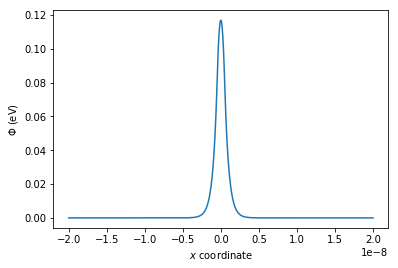

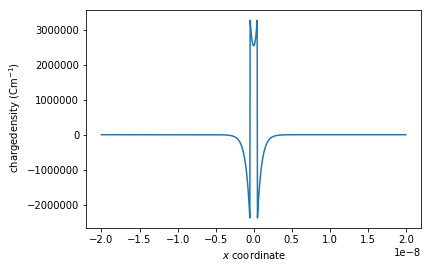

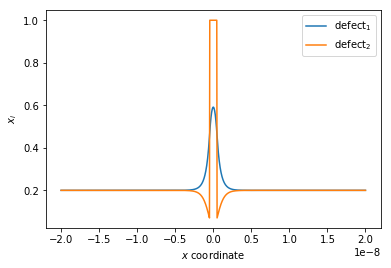

In [7]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

**Example 2**

```
boundary_conditions = dirichlet
site_models = site_explicit
```

The next example also has a series of sites with $x$ coordinates on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings), however defects are specific to their sites. In this example, there is a site with two positively charged defects, followed by two sites which each have one negatively charged defects. This system almost simulates a system such as gadolinium doped ceria which has a +2 defect followed by two -1 defects, however using two defects which are equal but opposite in their valence. The concentration and positively and negatively charged defects are equal and therefore the system is charge neutral. In this case all of the sites have a segregation energy of zero which demonstrates how the defects would be arranged in the bulk structure and how this affects the potential.

In this example, Dirichlet boundary conditions are enforced which ensures the potential at the boundary sites is 0.0.

In [8]:
data_1 = '../input_data/example_data_3_alternate_sites.txt'

In [9]:
site_models = 'site_explicit'

limits, laplacian_limits = calculate_grid_offsets( data_1, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data_1, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()

--- 770.5673627853394 seconds ---


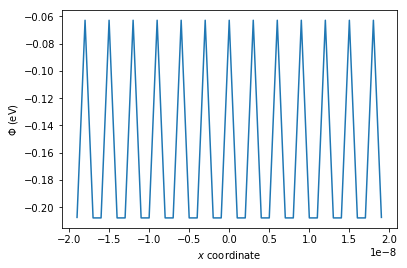

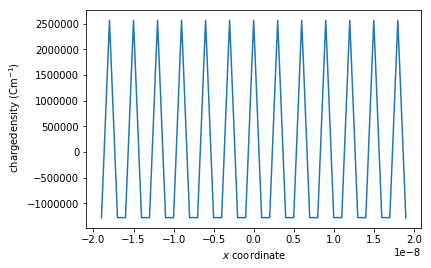

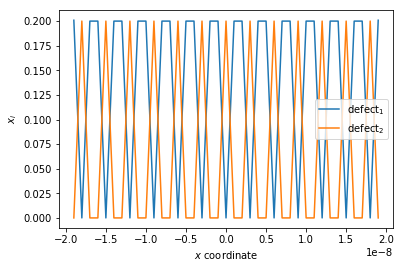

In [10]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

**Example 3**

```
boundary_conditions = periodic
site_models = site_explicit
```

When using Dirichlet boundary conditions the potential at the boundary sites is fixed to 0.0. It can be seen from the figure above showing the potential against the $x$ coordinate, with this example using data which depicts alternating sites, the potential profile curves. This happens because no matter what the potential is calculated to be, the potential is forced to zero at the boundaries. In this example, the boundary sites are occupied by negatively charged defects and therefore these sites should have a slightly negative potential. The Dirichlet boundary conditions force these sites to have a potential of zero and therefore the potential profile curves. The change in the potential profile effects the charge density, causing the system to become negatively charged, losing charge neutrality. 

To prevent this from happening periodic boundary conditions can be enforced. Periodic boundary conditions consider the region of data as a unit cell with the final site equivalent to the initial site but not fixed to any particular value.

In [11]:
boundary_conditions = 'periodic'

limits, laplacian_limits = calculate_grid_offsets( data_1, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data_1, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()

--- 1379.4808077812195 seconds ---


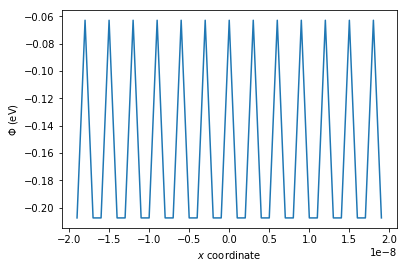

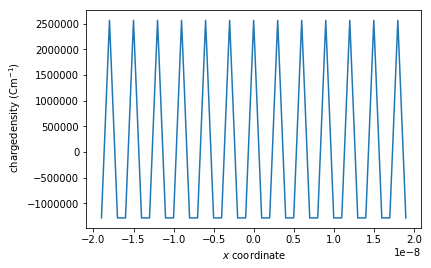

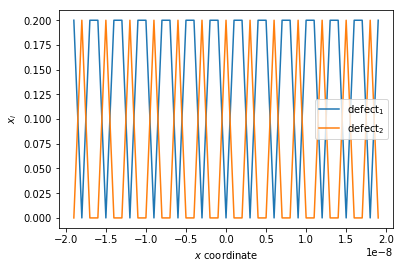

In [12]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()

**Example 4**

As shown above, when the periodic boundary conditions are used, the average charge across the system is 0.0 and the boundary potential is no longer being forced to 0.0 but is calculated along with the other sites using the Poisson-Boltzmann solver. 
The periodic boundary conditions can also be used with a system similar to the first example, where the central defect has a segregation energy of -1.0 eV but where the defects are specific to their sites.

In [13]:
data_2 = '../input_data/example_data_4_alternate_sites_one_defect.txt' 

In [14]:
boundary_conditions = 'periodic'

limits, laplacian_limits = calculate_grid_offsets( data_2, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data_2, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'site_2' ):
                site.defect_with_label('defect_2').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()

--- 1409.6890168190002 seconds ---


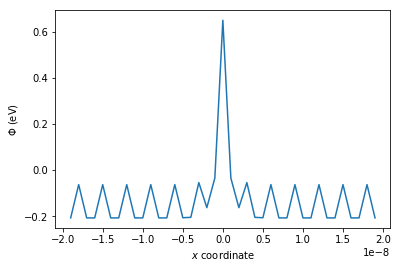

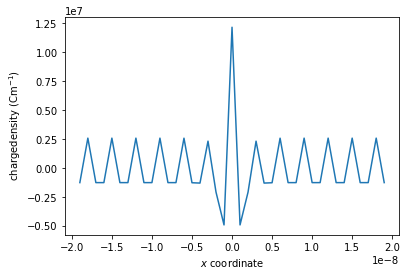

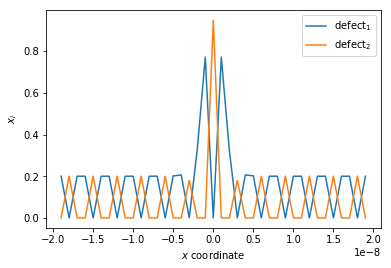

In [15]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()